In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

In [59]:
# Read in CSV
df = pd.read_csv('final_clean_car_data.csv')
df.head()

,year,make,model,body,transmission,state,condition,odometer,color,interior,mmr,sellingprice,saledate
0,2015,kia,sorento,suv,automatic,ca,5.0,16639.0,white,black,20500,21500,2014
1,2015,kia,sorento,suv,automatic,ca,5.0,9393.0,white,beige,20800,21500,2014
2,2014,bmw,3 series,sedan,automatic,ca,4.5,1331.0,gray,black,31900,30000,2015
3,2015,volvo,s60,sedan,automatic,ca,4.1,14282.0,white,black,27500,27750,2015
4,2015,nissan,altima,sedan,automatic,ca,1.0,5554.0,gray,black,15350,10900,2014


In [60]:
# Set all string values to upper case
for col in df.columns:
    if df[col].dtype == 'O':
        df[col] = df[col].str.upper()

# 'body' column contains too many unique values, as many use proprietary terms (e.g. 'CREWMAX CAB')
# Once we know what body type they refer to, we can consolidate them into a reasonable set of categories.
df.loc[df['body'].str.contains('CAB|SUPERCREW'), 'body'] = 'PICKUP'
df.loc[df['body'].str.contains('VAN'), 'body'] = 'VAN'
df.loc[df['body'].str.contains('SEDAN'), 'body'] = 'SEDAN'
df.loc[df['body'].str.contains('COUPE|KOUP'), 'body'] = 'COUPE'
df.loc[df['body'].str.contains('CONVERTIBLE'), 'body'] = 'CONVERTIBLE'
df.loc[df['body'].str.contains('WAGON'), 'body'] = 'WAGON'

df['body'].value_counts()

body
SEDAN          211452
SUV            112840
PICKUP          36308
VAN             25686
HATCHBACK       23508
COUPE           16537
WAGON           14016
CONVERTIBLE      8637
Name: count, dtype: int64

In [61]:
# Create a 'year' column represeting years passed between the car's year and the sale year
df['age'] = df['saledate'] - df['year']

In [62]:
# Remove cars with an odometer of less than 50. Most of these have an odometer of 1, which is either erroneous or not a used car. Either way it doesn't belong in the data.
df = df[df['odometer'] >= 50]

In [63]:
#There are a lot of car makes in the data, and many only have a small portion of the overall sales. I will be analyzing only the top 25 makes, by number of used cars sold.
top25_makes = sorted(list(df['make'].value_counts()[:25].index))
df = df[df['make'].isin(top25_makes)]

In [64]:
# Creating mileage bins: one bin every 5,000 miles
od_range = list(range(0, 205000, 5000))
df['od_bin'] = pd.cut(df['odometer'], od_range, labels=od_range[1:])

<Axes: ylabel='Frequency'>

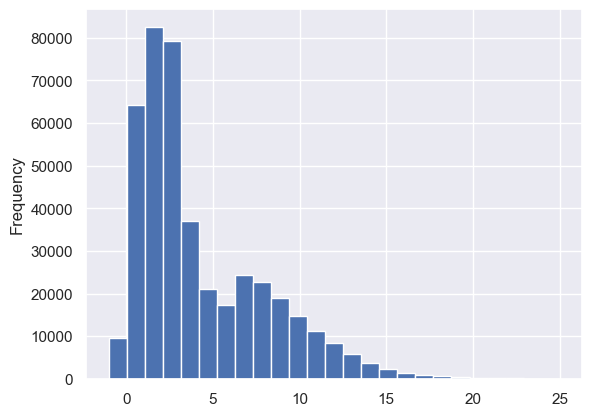

In [136]:
df[['odometer', 'age', 'condition', 'sellingprice']].corr()
df['age'].plot(kind='hist', bins=25)

1000


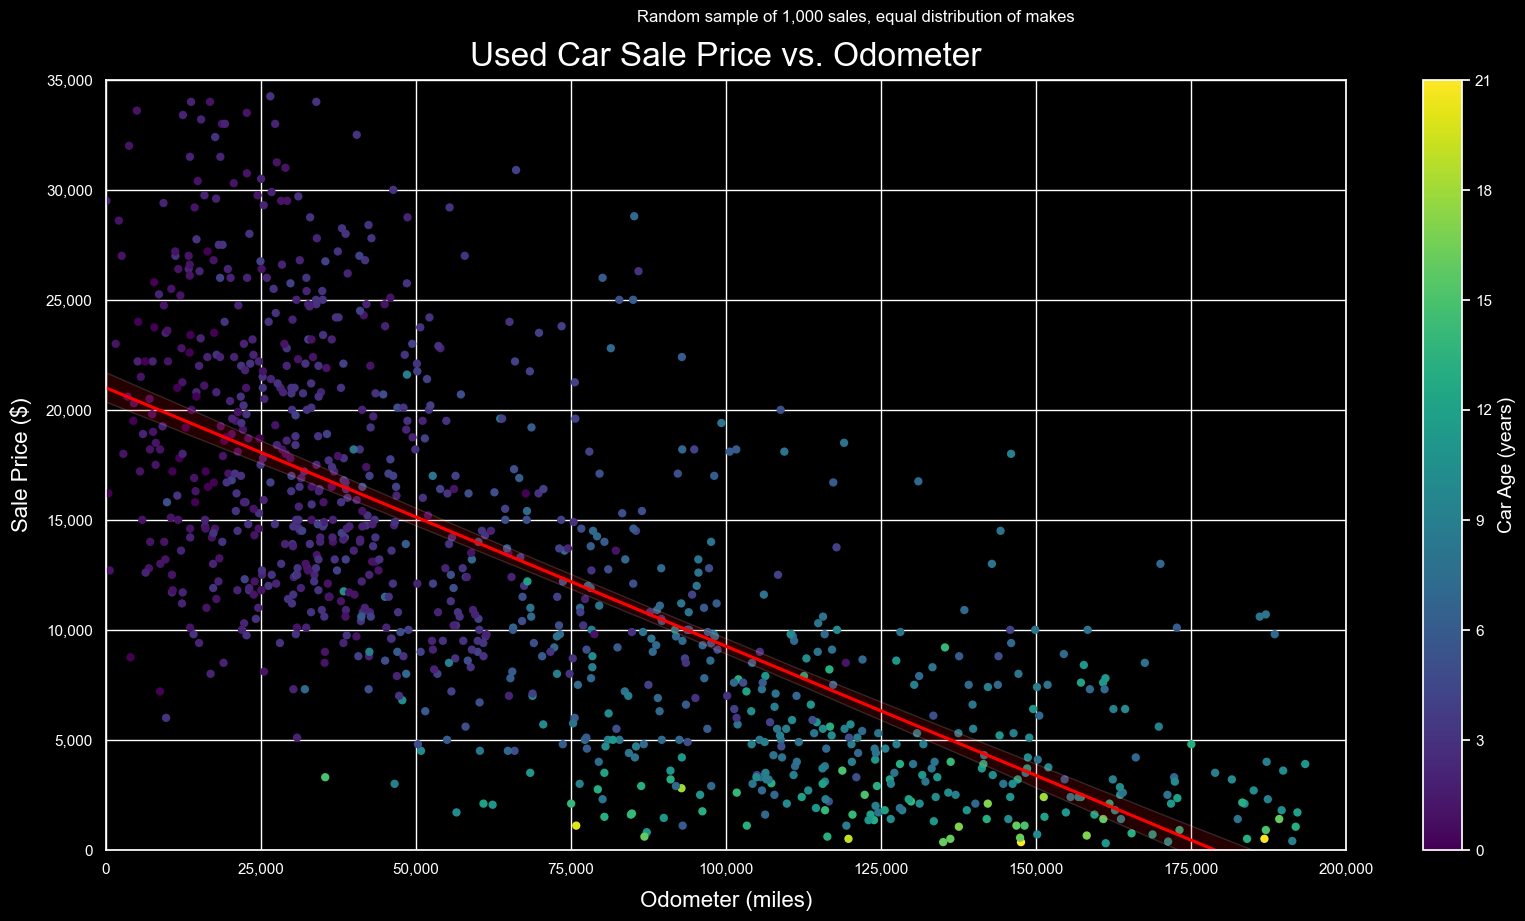

In [157]:
# The full dataset has far too many records for a scatterplot, so we will grab a random sample of 1000
#sampled = df.sample(1000, random_state=1)
sampled = df.groupby('make').sample(40, random_state=1)
print(len(sampled))

# Create a plot
fig, ax = plt.subplots(figsize=(20, 10))
plt.ylim(0, 35000)
plt.xlim(0, 200000)
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Plotting using Seaborn
#sns.scatterplot(data=sampled, x="odometer", y="sellingprice", hue="age", ax=ax, palette='plasma', edgecolor='none')
scatter = ax.scatter(sampled['odometer'], sampled['sellingprice'], c=sampled['age'], cmap='viridis', edgecolor='none')
sns.regplot(data=sampled, x='odometer', y='sellingprice', scatter = False, line_kws={'color': 'red'})

# Set axis labels
ax.set_xlabel('Odometer (miles)', color='white', fontsize=16, labelpad=10)
ax.set_ylabel('Sale Price ($)', color='white', fontsize=16, labelpad=10)
ax.set_title('Used Car Sale Price vs. Odometer', fontsize=24, pad=10)
fig.suptitle('Random sample of 1,000 sales, equal distribution of makes', fontsize=12, color='white', y=0.95)

# Adjust plot elements to be visible against black background
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Format x tick labels to have commas in the thousands place
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))

# Add a colorbar
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Car Age (years)', fontsize=14, color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
cbar.locator = ticker.MaxNLocator(integer=True)
cbar.update_ticks()

# Show the plot
plt.show()

In [158]:
body = df.groupby(['body', 'od_bin'])['sellingprice'].mean().reset_index()
body = pd.DataFrame(body)
body['percentage_diff'] = body.groupby('body')['sellingprice'].transform(lambda x: (x - x.iloc[0]) / x.iloc[0] * 100)
body

C:\Users\Alex School\AppData\Local\Temp\ipykernel_33116\2985063751.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  body = df.groupby(['body', 'od_bin'])['sellingprice'].mean().reset_index()


,body,od_bin,sellingprice,percentage_diff
0,CONVERTIBLE,5000,25285.802469,0.000000
1,CONVERTIBLE,10000,23427.533784,-7.349060
2,CONVERTIBLE,15000,24046.351931,-4.901765
3,CONVERTIBLE,20000,24300.000000,-3.898640
4,CONVERTIBLE,25000,24030.600000,-4.964060
...,...,...,...,...
315,WAGON,180000,2027.118644,-87.501011
316,WAGON,185000,2211.702128,-86.362890
317,WAGON,190000,1884.444444,-88.380724
318,WAGON,195000,1844.090909,-88.629540


c:\Users\Alex School\.conda\envs\myenv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alex School\.conda\envs\myenv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Alex School\.conda\envs\myenv\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Alex School\.conda\envs\myenv\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping w

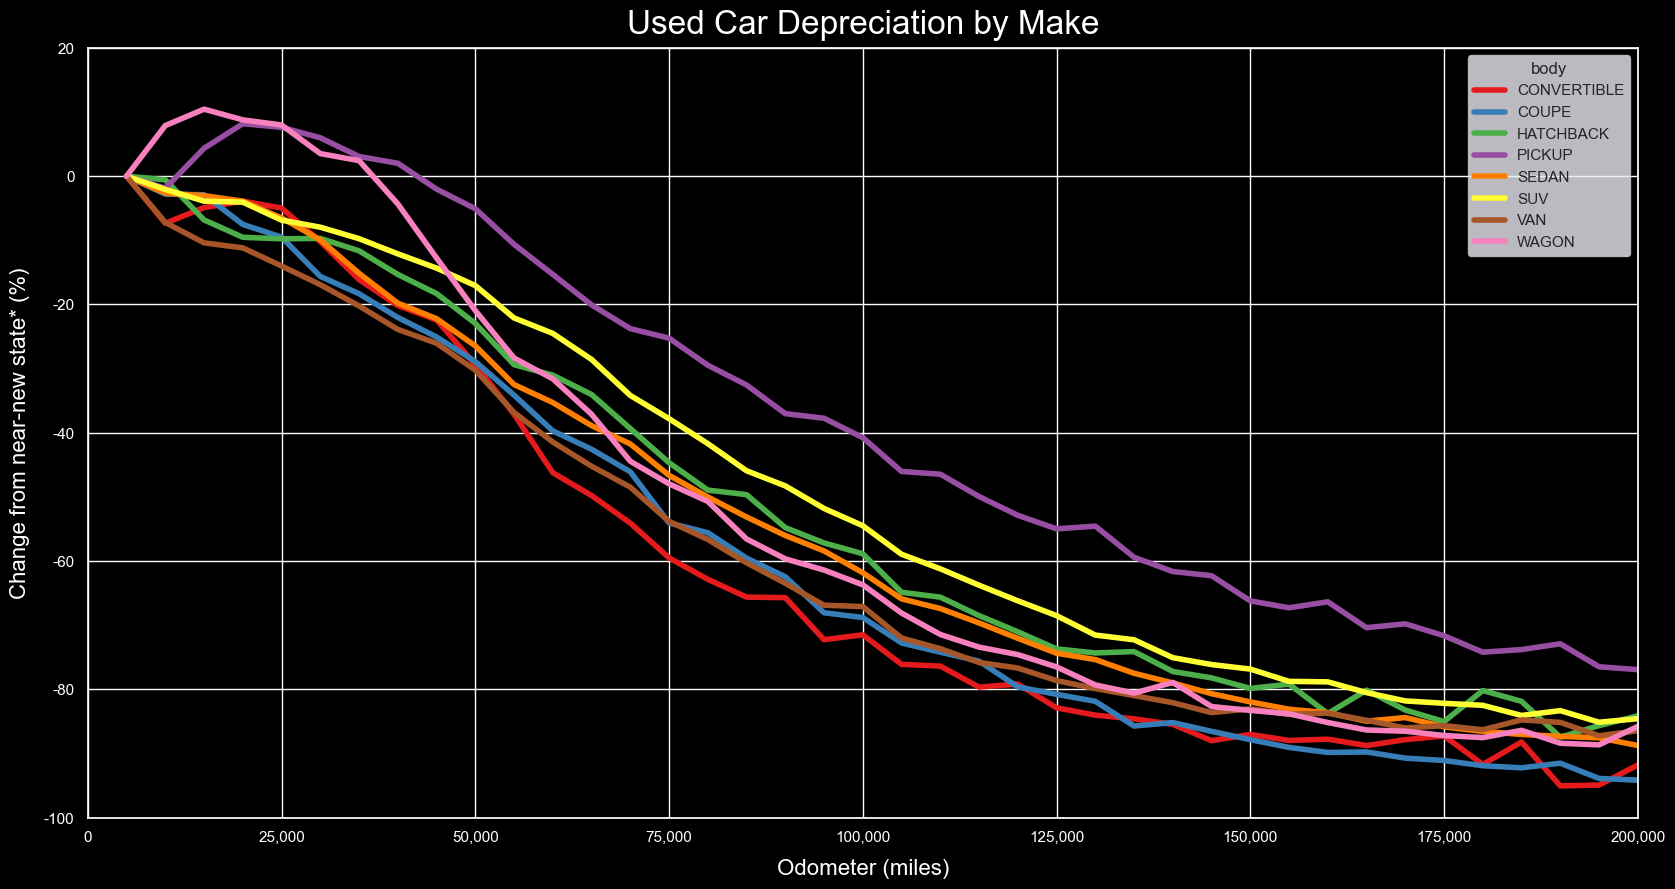

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Generate a rainbow colormap
rainbow_palette = sns.color_palette("Set1", n_colors=len(body['body'].unique()))

# Create a plot
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=body, x='od_bin', y='percentage_diff', hue='body', palette=rainbow_palette, linewidth=4)
plt.ylim(-100, 20)
plt.xlim(0, 200000)
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Set axis labels
ax.set_xlabel('Odometer (miles)', color='white', fontsize=16, labelpad=10)
ax.set_ylabel('Change from near-new state* (%)', color='white', fontsize=16, labelpad=10)
ax.set_title('Used Car Depreciation by Make', fontsize=24, pad=10)

# Adjust plot elements to be visible against black background
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Format x tick labels to have commas in the thousands place
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))

# Increase line width in legend
for line in ax.get_legend().get_lines():
    line.set_linewidth(4)

plt.show()

In [ ]:
od_group = df[df['make'].isin(top25_makes)].groupby(['make', 'od_bin'])['sellingprice'].mean().reset_index()
od_group = pd.DataFrame(od_group)
od_group['percentage_diff'] = od_group.groupby('make')['sellingprice'].transform(lambda x: (x - x.iloc[0]) / x.iloc[0] * 100)


od_group_hmm = od_group[od_group['od_bin'].isin([50000, 100000, 150000, 200000])]
od_group_hmm

In [ ]:
# Initialize the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Load the example car crash dataset
data = depdf.sort_values(by=200000, ascending=False)

# Plot the total crashes
sns.barplot(x=200000, y=data.index, data=data,
            label="200,000", color="#cc1002")

sns.barplot(x=150000, y=data.index, data=data,
            label="150,000", color="#fa4032")

sns.barplot(x=100000, y=data.index, data=data,
            label="100,000", color="#fc665b")

sns.barplot(x=50000, y=data.index, data=data,
            label="50,000", color="#fc8c83")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Make",
       xlabel="Percentage value lost")
#sns.despine(left=True, bottom=True)